The textbook example of the Jack's car rental problem with the limit of 20 cars per rental.

In [1]:
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt

In [2]:
N_MAX_CARS = 20

A_MAX = 5

LAMBDA = [3, 4]

MU = [3, 2]

GAMMA = 0.9

R_A = -2

R_X = 10

### Calculate Reward matrix

In [3]:
# Reward as a function of (N1'', N2'')
# Total reward is R_X + R_A * |a|
def right_tail(p):
    """
    Adjust the last value to account for an overflow over N_MAX_CARS
    """
    p[-1] = 1 - np.sum(p[:-1])
    return p


def make_reward_xi(Lambda):
    """
    Rewards(Xi) = sum_i^{Ni''} Xi p(Xi | lambda, Ni'')
    """
    X = np.arange(N_MAX_CARS + 1)

    p = poisson.pmf(X, Lambda)
    Ex = np.zeros(X.shape)
    
    for N__ in range(N_MAX_CARS + 1):
        p_N__ = right_tail(p[:N__ + 1].copy())
        Ex[N__] = np.sum(X[:N__ + 1] * p_N__)

    return Ex

R_N1 = make_reward_xi(LAMBDA[0])
R_N2 = make_reward_xi(LAMBDA[1])

R_N__ = R_X * (R_N1[:, np.newaxis] + R_N2)  # R_X[N1", N2"]

### Calculate Transition Probabilities

In [4]:
def make_likelihood(Lambda, Mu):
    """
    Create P(Ni' | Ni")
    """
    P = np.zeros((N_MAX_CARS + 1, N_MAX_CARS + 1))
    
    N = np.arange(N_MAX_CARS + 1)
    p = poisson.pmf(N, Lambda)
    px = []   
    for i in N: px.append(right_tail(p[:i+1].copy()))
    
    p = poisson.pmf(N, Mu)
    py = []
    for i in N: py.append(right_tail(p[:i+1].copy()))
    
    for N__ in range(N_MAX_CARS + 1):
        px_N__ = px[N__]

        for N_ in range(N_MAX_CARS + 1):     
            for x in range(N__ + 1):
                py_N_ = py[N_MAX_CARS - N__ + x]

                y = N_ - N__ + x
                if y < 0: continue

                P[N_, N__] += px_N__[x] * py_N_[y]
            
    return P

In [5]:
P1 = make_likelihood(LAMBDA[0], MU[0])
P2 = make_likelihood(LAMBDA[1], MU[1])

In [6]:
# Check the norm for conditional probability sum_N p(N | M) = 1
np.sum(P2, axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1.])

### Iterate Value

In [7]:
Value = np.zeros((N_MAX_CARS + 1, N_MAX_CARS + 1))
Policy = np.zeros((N_MAX_CARS + 1, N_MAX_CARS + 1), dtype=np.int16)

In [8]:
def IterValue(value, policy, toll=1e-3, max_iter=100):
    """
    Iterate value until maximum difference between sucsessive iteration is under tollerance threshold.
    """
    delta = 1
    it = 0
    
    while delta > toll and it < max_iter:
        it += 1

        value_new = np.zeros(value.shape)
        # Combine all matrixes in (N1'', N2'') on the right-hand-side of the Bellmans Equation
        RHS_N__ = R_N__ + GAMMA * P1.T.dot(value).dot(P2)

        for N1 in range(value.shape[0]):
            for N2 in range(value.shape[1]):
                a = policy[N1, N2]
                N1__ = N1 - a
                N2__ = N2 + a
                
                if N1__ < 0 or N1__ > N_MAX_CARS: continue
                if N2__ < 0 or N2__ > N_MAX_CARS: continue

                value_new[N1, N2] = RHS_N__[N1__, N2__] + R_A * abs(a)

        delta = np.max(np.abs(value - value_new))
        value = value_new
    
    if (it < max_iter): print(f"Value iteration converged in {it} iterations.")
    else: print(f"Too many iteration. Final delta --- {delta}.")
        
    return value

In [9]:
%%time
Value = IterValue(Value, Policy)

Too many iteration. Final delta --- 0.0014313359032485096.
CPU times: user 261 ms, sys: 0 ns, total: 261 ms
Wall time: 285 ms


### Improve Policy

In [10]:
def ImrovePolicy(value, policy):
    """
    Apply policy improvement part of the algorithm.
    """
    # Combine all matrixes in (N_, N__) on the right-hand-side of the Bellmans Equation
    RHS_N__ = R_N__ + GAMMA * P1.T.dot(value).dot(P2)

    for N1 in range(value.shape[0]):
        for N2 in range(value.shape[1]):
            v_max = -np.inf
            a_max = 0
            for a in range(-A_MAX, A_MAX + 1):
                N1__ = N1 - a
                N2__ = N2 + a
                              
                if N1__ < 0 or N1__ > N_MAX_CARS: continue
                if N2__ < 0 or N2__ > N_MAX_CARS: continue
                
                v_candidate = RHS_N__[N1__, N2__] + R_A * abs(a)
                
                if v_candidate > v_max:
                    v_max = v_candidate
                    a_max = a
            
            policy[N1, N2] = a_max

    return policy

In [11]:
%%time
Policy = IterValue(Value, Policy)

Value iteration converged in 4 iterations.
CPU times: user 27.5 ms, sys: 207 µs, total: 27.7 ms
Wall time: 26.4 ms


## Iterative Policy Optimisation Algorithm

In [12]:
# Initialize Policy and Value
Value = np.zeros((N_MAX_CARS + 1, N_MAX_CARS + 1))
Policy = np.zeros((N_MAX_CARS + 1, N_MAX_CARS + 1), dtype=np.int16)

it = 0
plt.rcParams.update({'font.size': 22})

Value iteration converged in 7 iterations.


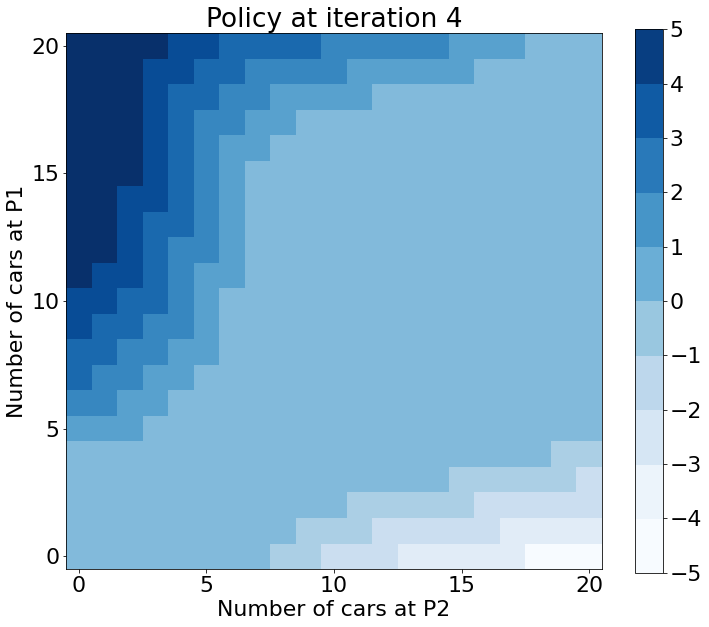

In [17]:
# Re-run this cell for further iterations

Value = IterValue(Value, Policy, toll=1e-3)
Policy = ImrovePolicy(Value, Policy)

plt.figure(figsize=(12, 10))
plot = plt.imshow(Policy, cmap=plt.get_cmap("Blues"))
plt.gca().invert_yaxis()

bounds = np.arange(-A_MAX, A_MAX + 1)

plt.colorbar(plot, boundaries=bounds, ticks=bounds)
plt.title(f"Policy at iteration {it}")
plt.xlabel("Number of cars at P2")
plt.ylabel("Number of cars at P1")
plt.yticks(np.arange(0, 21, 5))
plt.xticks(np.arange(0, 21, 5))
plt.show()

it += 1
None

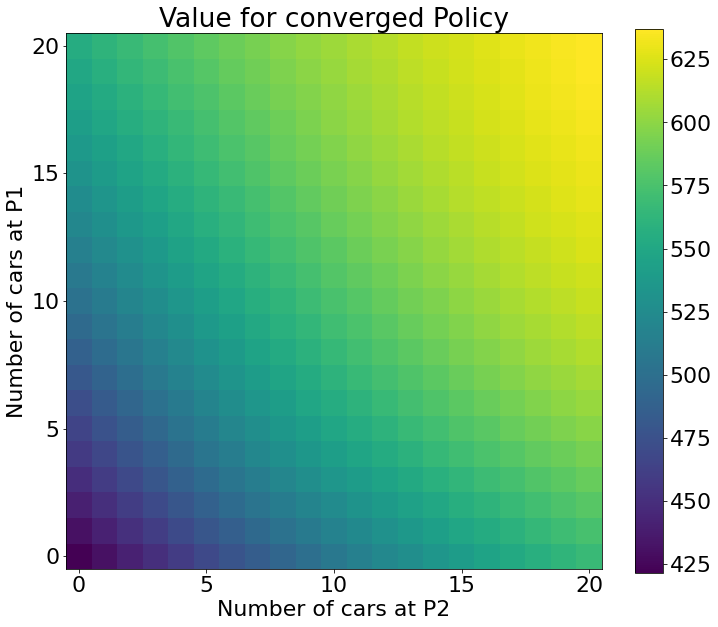

In [18]:
plt.figure(figsize=(12, 10))
plot = plt.imshow(Value)
plt.gca().invert_yaxis()
plt.colorbar(plot)

plt.title(f"Value for converged Policy")
plt.xlabel("Number of cars at P2")
plt.ylabel("Number of cars at P1")
plt.yticks(np.arange(0, 21, 5))
plt.xticks(np.arange(0, 21, 5))
plt.show()
None